In [14]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from tqdm.notebook import trange
%matplotlib inline

In [ ]:
np.random.seed(42)

# model Levy process

In [2]:
def brownian(t: np.ndarray):
    return np.cumsum(np.random.randn(t.shape[0])) * np.sqrt(t[1] - t[0])


def f_1(x, nu: Callable, l, eps):
    assert l > 0, "invalid sampling params"
    if abs(x) < eps:
        return 0
    else:
        return nu(x) / l


def sample_f(nu: Callable, l, eps, m=10**6):
    """
    sample f-distributed iid rv
    using accept-reject method
    :param nu: d(nu)/dx
    :param l: lambda
    :param eps: epsilon
    :param m: number of samples in unif
    :return: f-distributed iid rv
    """
    u = np.random.uniform(size=[m,2])
    fu = np.array([
        f_1(x,nu,l,eps) for x in u[:,0]
    ])
    scale = fu.max()
    return np.array([
        u[i,1] for i in range(u.shape[0])
        if u[i,1]*scale <= fu[i]
    ])


def pp(t: np.ndarray, l):
    dt = t[1] - t[0]
    values = [0]
    for i in range(t.shape[0]-1):
        values.append(values[-1] + np.random.poisson(l*dt))

    return np.array(values)


def cpp(t: np.ndarray, nu:Callable, l, eps):
    res = []
    xi = sample_f(nu, l, eps)
    pois = pp(t, l)
    for i in range(t.shape[0]):
        if pois[i] > xi.shape[0]:
            xi_1 = sample_f(nu, l, eps)
            xi = np.array(list(xi).append(list(xi_1)))

        res.append(xi[:pois[i]].sum())
    return res

def levy_1(t: np.ndarray, m0, sigma,
           l, eps, nu: Callable):
    brm = brownian(t)
    y = m0*t + sigma*brm
    z = cpp(t, nu, l, eps)
    return y + z

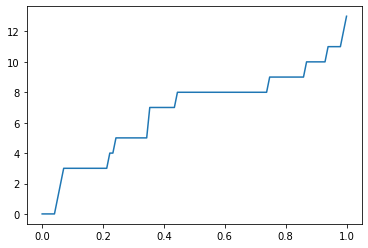

In [3]:
t = np.linspace(0,1,100)
pois = pp(t,12)
plt.plot(t,pois)

In [4]:
def nu_1(x, alpha=1/2):
    return (np.ones(x.shape)+0.5*np.cos(x)**2) / \
           (np.abs(x)**(1+alpha))


def nu_2(x):
    return np.exp(-x) / x

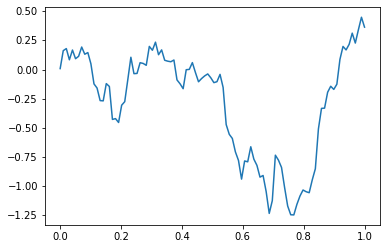

In [5]:
t = np.linspace(0,1,100)
x1 = levy_1(t,
           m0=0, sigma=1,
           l = 1, eps = 1/2,
           nu = nu_2)
plt.plot(t,x1)

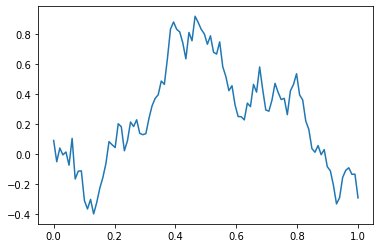

In [6]:
t = np.linspace(0,1,100)
x2 = levy_1(t,
           m0=0, sigma=1,
           l = 2, eps = 1/7,
           nu = nu_1)
plt.plot(t,x2)

# estimate call option :)

In [7]:
def f(x, m=0.1):
    return (x - m) * (x-m > 0)

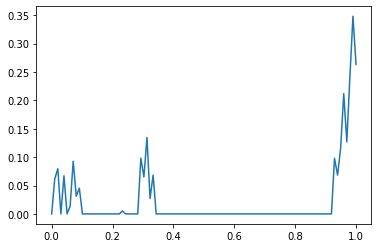

In [11]:
f_x1 = f(x1)
plt.plot(t,f_x1)

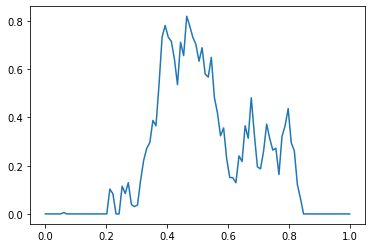

In [12]:
f_x2 = f(x2)
plt.plot(t,f_x2)

In [16]:
N = 100
t = np.linspace(0,1,100)

processes_1 = []
processes_2 = []
for _ in trange(N):
    x1 = levy_1(t,
               m0=0, sigma=1,
               l = 1, eps = 1/2,
               nu = nu_1)
    processes_1.append(f(x1))
    x2 = levy_1(t,
               m0=0, sigma=1,
               l = 1, eps = 1/2,
               nu = nu_2)
    processes_2.append(f(x2))

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
# processes_11 = np.array(processes_1)
# processes_22 = np.array(processes_2)
#
# p1 = processes_11.mean(axis=1)
# p2 = processes_22.mean(axis=1)
#
# fig, axs = plt.subplots(nrows=2, figsize = (10, 20))
# axs[0].plot(t, p1)
# axs[1].plot(t, p2)
# fig.show()